# Gamma Distribution_Python

## Polecenie:

Zadanie 1 

Dany jest rozkład Gamma z parametrami k=2, θ=1. Ile wynosi teoretyczna średnia w tym rozkładzie? 
Wygeneruj 1000 prób z tego rozkładu. Dla każdej próby oszacuj przedział ufności 95% dla średniej używając następujących metod:

	a. Klasycznej metody z przybliżeniem z rozkładu normalnego (np. komenda mean w Stata).
	b. Metody Bootstrap gdzie percentyle z b-podpróbek bootstrapowych są uznawane za granice przedziału ufności (przyjmij b=200).
    
    
Jak często w obydwu metodach przedział ufności pokrył wartość średniej? Skomentuj różnice.


### Rozkład Gamma zależy od dwóch parametrów, $k$ i $\theta$ i wygląda tak:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gamma


def make_gammas(ks, thetas, x):
    res = {}
    ordered_keys = []
    for theta in sorted(thetas):
        for k in sorted(ks):
            name = '$k$=' + str(k) + '; $\\theta$=' + str(theta)
            res[name] = gamma.pdf(x, k, scale=theta)
            ordered_keys.append(name)

    return pd.DataFrame(res)[ordered_keys]

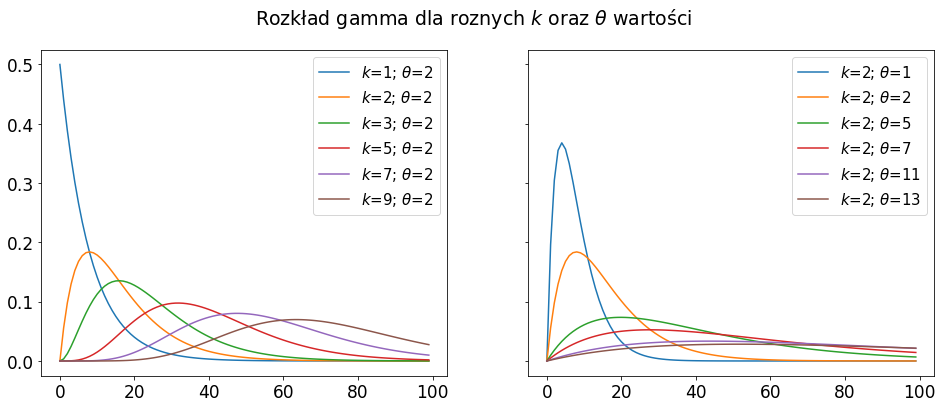

In [2]:
gamma_df_k = make_gammas([1,2,3,5,7,9], [2], np.linspace(0,25, num=100))
gamma_df_theta = make_gammas([2],[1,2,5,7,11,13], np.linspace(0,25, num=100))

fig, axarr = plt.subplots(1,2,figsize=(16,6), sharey=True)
gamma_df_k.plot(ax=axarr[0], fontsize=17)
axarr[0].legend(fontsize=15)
gamma_df_theta.plot(ax=axarr[1], fontsize=17)
axarr[1].legend(fontsize=15)
plt.suptitle('Rozkład gamma dla roznych $k$ oraz $\\theta$ wartości', fontsize=19)
plt.show()

Z powyższych wykresów widzimy, że zarówno $k$, jak i $\theta$ wpływają na wygląd rozkładu Gamma. Dla $k$=1, rozkład Gamma jest po prostu wykładniczym rozkładem (maksymalna asymetria), a dla $k > \ok $9 pdf zbliża się do Gaussa (symetria). 

Niższe wartości $\theta$ ściskają rozkład poziomo w lewo; wyższe wartości rozciągają go i spłaszczają, ale nie ma to wpływu na ogólny profil.

Parametry $k$ i $\theta$ są ze sobą powiązane poprzez średnią i wariancję rozkładu gamma.

## Szacowanie k oraz przedziałów ufności

Niepewność jest odwrotnie proporcjonalna do $\sqrt{n}$. 

Efekt ten można zmierzyć empirycznie, wielokrotnie oszacowując $k$ wiele razy dla różnych wielkości próbek i obserwując wynikowy rozkład próbkowania.

Za pomocą metody bootstrap można obliczyć przedziały ufności wokół oszacowań.

## Metoda momentów

Za pomocą metody momentów ustawia się momenty empiryczne (średnia, wariancja itp.) na ich teoretyczne wyrażenie w postaci parametrów rozkładu, a następnie rozwiązuje się parametry. Dla rozkładu gamma wiemy, że średnia $\mu=k\theta$ i wariancja $\sigma^2=k\theta^2$.

In [3]:
import numpy as np
def gamma_mom(x):
    avg = np.mean(x)
    var = np.var(x)
    k = avg ** 2 / var
    theta = var / avg

    return k, theta

## Szacowanie maksymalnego prawdopodobieństwa

Dzięki MLE maksymalizuje się funkcję wiarygodności obserwowanych danych w stosunku do parametrów Gamma. W przypadku Gammy nie ma wyrażenia w formie zamkniętej dla maksimum jako funkcji parametrów, więc musimy uciec się do metod numerycznych.

Dla pojedynczej wartości $k$, wygenerujmy wiele rysunków z samouzgodnieniem (bootstrap) odpowiadających wartości gamma i porównajmy rozkłady próbkowania dla oszacowań uzyskanych z MoM i MLE.

In [4]:
def gamma_bootstrap_estimate(true_k, true_theta, sample_size=[50, 100, 1000], draws=100, method='all'):
    true_mean = true_k * true_theta
    true_var = true_k * true_theta ** 2

    result = []
    for this_many in sample_size:

        # Generate this_many samples from the true Gamma
        rvs = [gamma.rvs(true_k, scale=true_theta, size=this_many)
               for n in range(draws)]

        if method == 'all' or method == 'scipy':
            estimates_scipy = (gamma.fit(x, floc=0) for x in rvs)
            (k_scipy, loc_scipy, theta_scipy) = zip(*estimates_scipy)
            result.append({'sample_size': this_many, 'k_estimate': k_scipy, 'theta_estimate': theta_scipy,
                           'true_theta': true_theta, 'true_k': true_k, 'method': 'scipy'})

        if method == 'all' or method == 'mom':
            estimates_mom = (gamma_mom(x) for x in rvs)
            (k_mom, theta_mom) = zip(*estimates_mom)
            result.append({'sample_size': this_many, 'k_estimate': k_mom, 'theta_estimate': theta_mom,
                           'true_theta': true_theta, 'true_k': true_k, 'method': 'mom'})

    return pd.concat([pd.DataFrame(r) for r in result])

In [5]:
true_k = 2
true_theta = 2
num_samples = [10, 25, 50, 100, 500, 1000]
num_draws = 1000
estimates_for_one_k = gamma_bootstrap_estimate(true_k, true_theta, num_samples, draws=num_draws)
estimates_for_one_k.head()


,sample_size,k_estimate,theta_estimate,true_theta,true_k,method
0,10,2.647573,1.644936,2,2,scipy
1,10,3.109101,1.046539,2,2,scipy
2,10,1.448785,4.239409,2,2,scipy
3,10,1.048390,2.792868,2,2,scipy
4,10,3.072902,1.608420,2,2,scipy


Wykres skrzypcowy to graficzna metoda analizy danych do bezpośredniego porównania dwóch rozkładów w różnych wartościach zmiennej grupującej (w naszym przypadku liczby próbek).

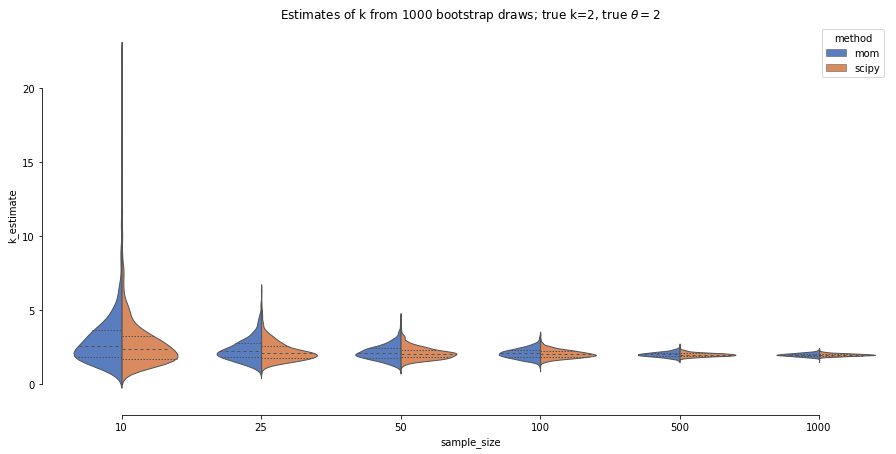

In [7]:
import seaborn as sns
plt.figure(figsize=(15,7))
ax = sns.violinplot(x='sample_size', y='k_estimate', data=estimates_for_one_k, hue='method', palette='muted',
               inner='quartile', split=True, hue_order=['mom', 'scipy'], linewidth=1)
sns.despine(offset=10, trim=True)
title_str = 'Estimates of k from ' + str(num_draws) + \
    ' bootstrap draws; true k=' + str(true_k) + \
    ', true $\\theta=$' + str(true_theta)
plt.title(title_str)
plt.show()

Widzę, że zarówno dla MoM, jak i MLE, rozrzut rozkładu próbkowania zmniejsza się wraz ze wzrostem liczby próbek. Znaliśmy go z centralnego twierdzenia granicznego (CLM). Widzę również, że rozrzut rozkładu próbkowania dla szacunków MoM jest nieco szerszy niż dla MLE, co sugeruje, że MLE może dać ci trochę więcej zaufania do szacunków. Następnie chcę dokładniej przyjrzeć się tym różnicom w spreadach i przetestować te obserwacje dla różnych wartości $k$.

Aby porównać szacunki dla $k$, normalizuję błąd do ułamka między -1 a 1. Zatrzymuję się na k=9, ponieważ dla wyższych wartości rozkład Gamma zaczyna wyglądać jak Gauss.

In [8]:
df_list = []
theta_val = 2
for k in [1,2,3,5,7,9]:
    tmp = gamma_bootstrap_estimate(k,theta_val, sample_size=num_samples, draws=num_draws)
    df_list.append(tmp)

big_df = pd.concat(df_list)
big_df['fractional_error'] = (big_df['k_estimate'] - big_df['true_k'] ) / big_df['true_k']
big_df.head()

,sample_size,k_estimate,theta_estimate,true_theta,true_k,method,fractional_error
0,10,0.757591,1.553897,2,1,scipy,-0.242409
1,10,1.182734,1.646462,2,1,scipy,0.182734
2,10,1.217993,0.721261,2,1,scipy,0.217993
3,10,1.914971,1.351008,2,1,scipy,0.914971
4,10,0.835979,2.067216,2,1,scipy,-0.164021


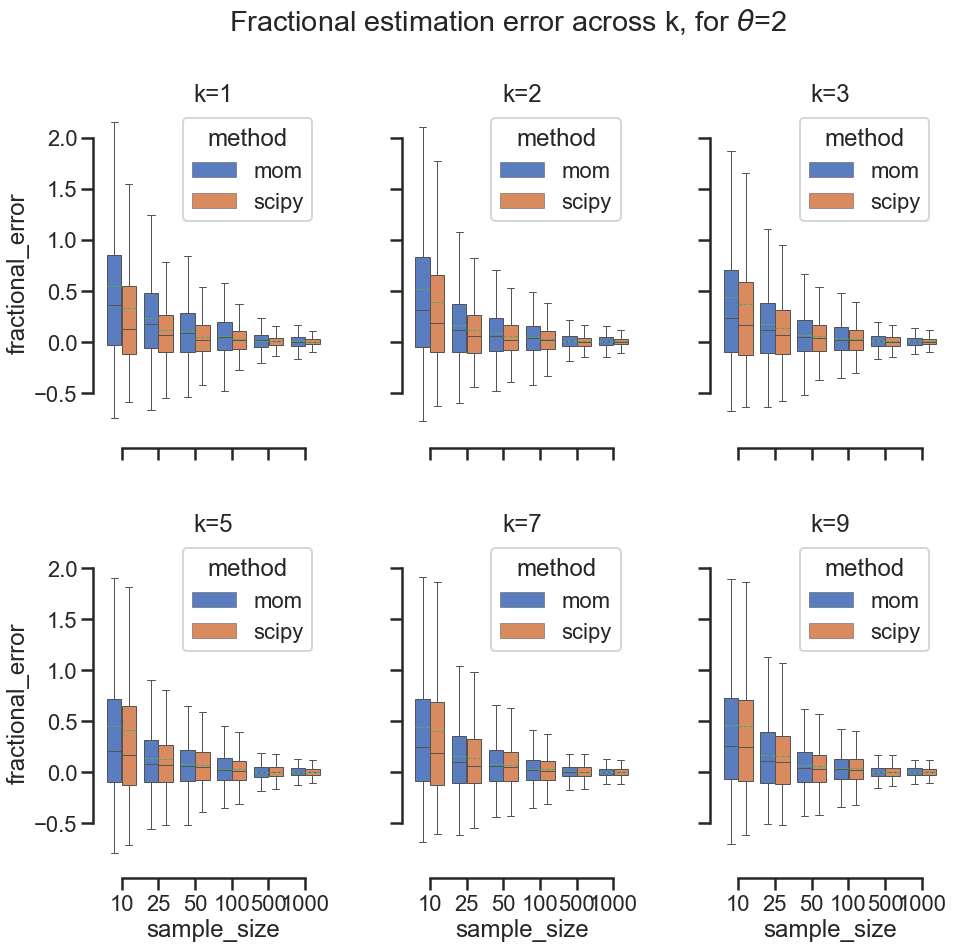

In [9]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

true_k = big_df['true_k'].unique()
num_k = len(true_k)
ncol=3
nrow= int(num_k / ncol)

sns.set(style="ticks")
sns.set_context("poster")
f, axarr = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(15,14))
for row in range(nrow):
    for col in range(ncol):
        idx = row * ncol + col
        this_ax = axarr[row,col]
        sns.boxplot(ax=this_ax, x="sample_size", y="fractional_error", hue='method', hue_order=['mom', 'scipy'],
                    data=big_df[big_df['true_k'] == true_k[idx] ], palette="muted",
                    showfliers=False,  linewidth=1, showmeans=True, meanline=True)
        this_ax.set_title('k='+str(true_k[idx]))
        if row == 0:
            this_ax.set_xlabel('')
        if col > 0:
            this_ax.set_ylabel('')

sns.despine(offset=10, trim=True)
plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.suptitle('Fractional estimation error across k, for $\\theta$='+str(theta_val))
plt.show()

## Przedziały ufności

Chcę oszacować przedziały ufności, więc obliczam kwantyle oszacowań $k$. Ponownie, aby ułatwić porównanie różnych prawdziwych wartości $k$ i wielkości próbek, przyjmuję metrykę błędu ułamkowego, ale przyjmuję jej wartość bezwzględną, aby uprościć wizualną eksplorację poniższych wykresów. W tym przypadku przyjęcie wartości bezwzględnej jest jak założenie, że błąd ułamkowy jest symetryczny wokół 0. Widzieliśmy powyżej, że tak nie jest w przypadku małych prób, ale dla próby 100 i większej jest to bardziej prawdopodobne.

In [10]:
q = [0.05,0.1,0.2,0.3, 0.4,0.5,0.6,0.7,0.8,0.9, 0.95, 0.975]
big_df['abs_fractional_error'] = big_df['fractional_error'].abs()
grouped = big_df.groupby(['method', 'sample_size', 'true_k'])
grouped_quantiles = grouped['abs_fractional_error'].quantile(q)
grouped_quantiles.name='fractional_error_quantile'

grouped_quantiles.index.names = map(lambda n: n if n is not None else 'confidence_level', grouped_quantiles.index.names)

quantiles_df = pd.DataFrame( pd.DataFrame(grouped_quantiles).to_records() )
quantiles_df.head()

,method,sample_size,true_k,confidence_level,fractional_error_quantile
0,mom,10,1,0.05,0.028804
1,mom,10,1,0.10,0.064819
2,mom,10,1,0.20,0.139241
3,mom,10,1,0.30,0.222295
4,mom,10,1,0.40,0.323286


<Figure size 1224x1080 with 0 Axes>

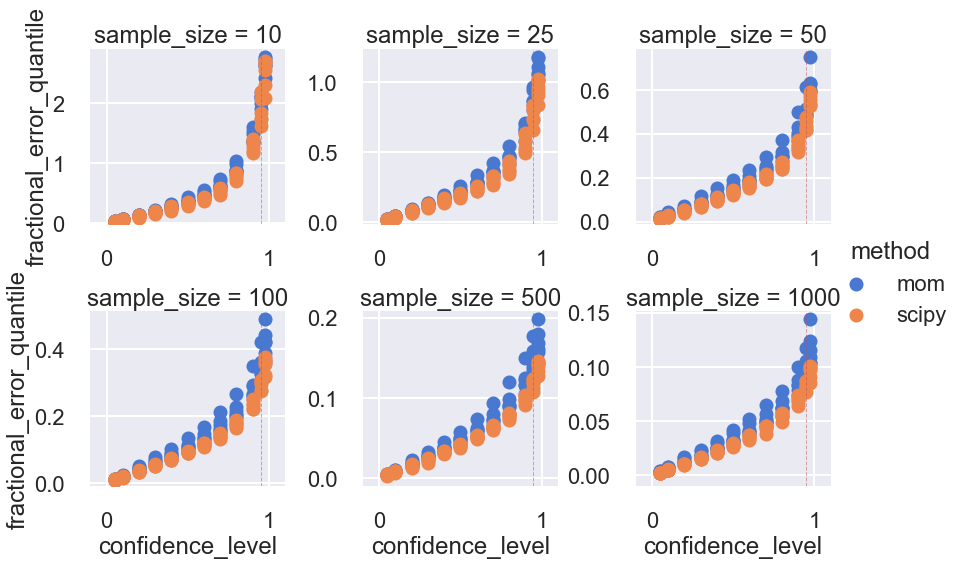

In [11]:
sns.set(style="darkgrid")
sns.set_context("poster")
f = plt.figure(figsize=(17, 15))
g = sns.FacetGrid(quantiles_df, despine=True, sharey=False, col_wrap=3, col='sample_size', height=4, legend_out=True,
                  hue='method', hue_order=['mom', 'scipy'], margin_titles=True, palette='muted', xlim=[-0.1, 1.1])
g.map(plt.scatter, "confidence_level", "fractional_error_quantile")

conf_level = 0.95
for ax in g.axes.flat:
    ylims = ax.get_ylim()
    new_ylims = [-0.01, ylims[1]]
    ax.set_ylim(new_ylims)
    ax.plot([conf_level, conf_level], new_ylims, 'r--', alpha=0.5, linewidth=1)

sns.despine(offset=10, trim=True)
g.add_legend()
g.fig.subplots_adjust(wspace=0.4, hspace=0.5)
plt.show()

Zbadałem związek między wielkością próbkowania, parametrami rozkładu Gamma i metodami estymacji przy użyciu metody ładowania początkowego i wizualizacji. To, co znalazłem, jest dobrze znane, nie tylko w przypadku rozkładów gamma: efekty próbkowania zmniejszają się wraz ze wzrostem wielkości próbki, a różne metody estymacji dają różne wyniki. Byłem również zainteresowany obliczeniem przedziałów ufności szacunków, z których mógłbym skorzystać w przyszłości. Teraz wiem na przykład, że jeśli chcę, aby moje oszacowanie $k$ mieściło się w $\pm$15% prawdziwej wartości w 95% przypadków, potrzebuję około 500 próbek. 